# Exploring - Prosper Rating 
##  Bethany Goss

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#Univariate Exploration"> Univariate Exploration</a></li>
<li><a href="#Bivariate Exploration">Bivariate Exploration</a></li>
<li><a href="#Multivariate Exploration">Multivariate Exploration</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>


<a id='intro'></a>
## Introduction

### Preliminary Wrangling

I am taking a look at a portion of Prosper's loan portfolio. This particular portion has 113,937 loans in it and has information ranging from application data to current payment status. https://knowledge.udacity.com/questions/693819
Base on this, I'll be lookin at mid July 2009 to the end of the dataset in March 2014.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
#loading the database and cutting it to July 2009 to March 2014
url="https://bethanygossportfolio.com/wp-content/uploads/2022/01/prosperLoanData.csv"
loans_d=pd.read_csv(url)
loans_d.sort_values(by=['LoanOriginationDate'], ignore_index=True, inplace=True)
loans_d=loans_d.iloc[28953:]
m_data=loans_d.copy()
m_data.reset_index(drop=True, inplace=True)
m_data.head()
m_data.LoanOriginationDate.tail()

84979    2014-03-12 00:00:00
84980    2014-03-12 00:00:00
84981    2014-03-12 00:00:00
84982    2014-03-12 00:00:00
84983    2014-03-12 00:00:00
Name: LoanOriginationDate, dtype: object

In [3]:
#making sure there are unique loan values.
m_data.LoanKey.nunique()
m_data.drop_duplicates(subset=['LoanKey'], inplace=True)
m_data.LoanKey.duplicated().sum()

0

In [4]:
m_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84113 entries, 0 to 84983
Data columns (total 81 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ListingKey                           84113 non-null  object 
 1   ListingNumber                        84113 non-null  int64  
 2   ListingCreationDate                  84113 non-null  object 
 3   CreditGrade                          0 non-null      object 
 4   Term                                 84113 non-null  int64  
 5   LoanStatus                           84113 non-null  object 
 6   ClosedDate                           26123 non-null  object 
 7   BorrowerAPR                          84113 non-null  float64
 8   BorrowerRate                         84113 non-null  float64
 9   LenderYield                          84113 non-null  float64
 10  EstimatedEffectiveYield              83982 non-null  float64
 11  EstimatedLoss               

I want to make sure my data is tidy. Here I am addressing any null values and have done a visual examination of my data in Excel to check for one measurement, one cell. 

In [5]:
#handling the prosper rating nullls & making sure that the Prosper Ratings match
m_data["ProsperRating (numeric)"].value_counts(), m_data["ProsperRating (Alpha)"].value_counts()
m_data.rename(columns={'ProsperRating (numeric)': 'ProsperRating', 'ListingCategory (numeric)': 'ListingCategory'}, inplace=True)
m_data.drop(labels=["ProsperRating (Alpha)"], axis=1, inplace=True)
m_data.ProsperRating.fillna(0.0, inplace=True)

In [6]:
#Looking for nulls in the categorical data
def finding_nulls(list_of_columns):
        for i in list_of_columns:
            return m_data[i].isnull().sum()
columns=["ListingCategory", "Recommendations", "BorrowerState", "EmploymentStatus"]
finding_nulls(columns)

0

In [7]:
#handling there DTI and Estimated Effective Yield nulls
m_data.DebtToIncomeRatio.isnull().sum()/m_data.shape[0] #8.5% of the dataset is null. I will fill in with the mean
m_data.EstimatedEffectiveYield.isnull().sum()/m_data.shape[0] # 0.16% of the dataset is null. I will fill in with the mean
def filling_means(column):
    dtimean=m_data.DebtToIncomeRatio.mean()
    column.fillna(dtimean, inplace=True)
    return column.isnull().sum()
filling_means(m_data.DebtToIncomeRatio)
filling_means(m_data.EstimatedEffectiveYield)

0

In [8]:
#there are indicators for full-time / part-time employment etc.  
#A logical conclusion is that those with "Employed" as their Employment status must have two or more types of employment.
m_data.EmploymentStatus.value_counts()
m_data.EmploymentStatus.replace("Employed", "Dual-employed", inplace=True)

In [9]:
m_data.shape

(84113, 80)

### What is the structure of your dataset?

There are 84,113 loans with 80 different characteristics ranging from loan number to open credit lines when credit for the loan was first pulled.

### What is/are the main feature(s) of interest in your dataset?

I will be looking specifically at Prosper Rating which is a unique part of Prosper's lending model. This is part of a risk "Prosper Score" given to borrowers based on past borrowers' behavior. The Prosper Rating is on a scale of 1- 11 with 1 being the worst and 11 being the best. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

This will be a discussion of indicators that are not reflected in a credit report that could impact the Prosper Rating such as a borrower's location, debt to income ratio, employment status, and recommenders, as well as a loan's type and estimated effective yield. I expect that a loan's estimated effective yield and the number of people recommending a borrower to have the most significant impact on Prosper Rating. 

<a id='Univariate Exploration'></a>
## Univariate Exploration

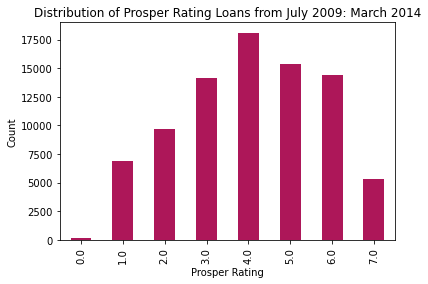

In [10]:
#distribution of prosper rating 
m_data.ProsperRating.value_counts().sort_index().plot.bar(color=sb.color_palette(palette="rocket_r")[3])
plt.xlabel("Prosper Rating")
plt.ylabel("Count")
plt.title("Distribution of Prosper Rating Loans from July 2009: March 2014");

It is interesting that there arent any loans that qualify for any of the 8-11 ratings. This is confirmed when I look at Prosper Rating's descriptive statistics. I think it could be interesting to see what would make a borrower qualify for these higher ratings. 

In [11]:
m_data.ProsperRating.describe()

count    84113.000000
mean         4.062368
std          1.681808
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: ProsperRating, dtype: float64

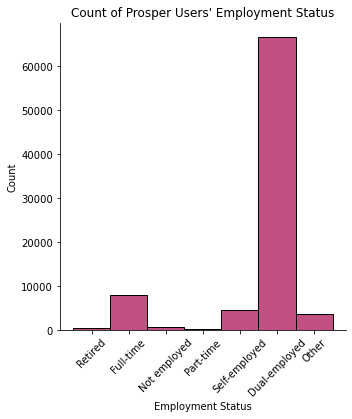

In [12]:
#Employment Status plot
sb.displot(m_data, x="EmploymentStatus", color=sb.color_palette(palette="rocket_r")[3])
plt.title("Count of Prosper Users' Employment Status")
plt.xticks(rotation=45)
plt.xlabel("Employment Status")
plt.ylabel("Count");

Most are in that now labeled Dual-Employed category. With full-time following as a far second. 

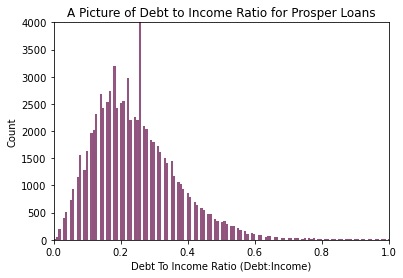

In [13]:
#getting a better look at the general figure of the data. Even when I logged it, it looked similar.
fig = plt.figure()
base_color = sb.color_palette(palette="rocket_r")[4]
sb.histplot(data = m_data, x = 'DebtToIncomeRatio', color = base_color)
plt.xlim([0,1])
plt.ylim([0,4000])
plt.xlabel("Debt To Income Ratio (Debt:Income)")
plt.title("A Picture of Debt to Income Ratio for Prosper Loans");

This graph is a smaller portion of the actual graph, but it still shows the same trend. 

In [14]:
#These are all values. DTI goes up to 1001%; values after 100% aren't in the graph because the trend doesn't change.
m_data.DebtToIncomeRatio.describe()

count    84113.000000
mean         0.258679
std          0.306039
min          0.000000
25%          0.160000
50%          0.240000
75%          0.310000
max         10.010000
Name: DebtToIncomeRatio, dtype: float64

In [15]:
m_data.EstimatedEffectiveYield.describe()

count    84113.000000
mean         0.169010
std          0.068645
min         -0.182700
25%          0.116600
50%          0.161620
75%          0.225400
max          0.319900
Name: EstimatedEffectiveYield, dtype: float64

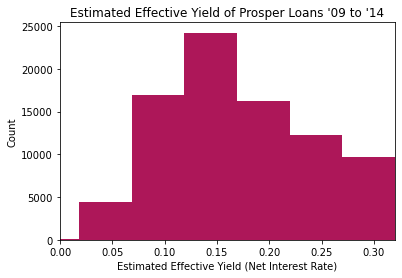

In [16]:
plt.hist(m_data.EstimatedEffectiveYield, color=sb.color_palette(palette="rocket_r")[3])
plt.xlim([0,0.32])
plt.title("Estimated Effective Yield of Prosper Loans '09 to '14")
plt.xlabel("Estimated Effective Yield (Net Interest Rate)")
plt.ylabel("Count");

I did cut off the negative Yield for a similar reason as the last graph, it showed the same trend. 

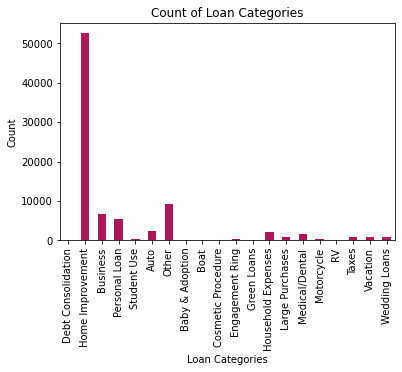

In [17]:
#Loan categories 
m_data.ListingCategory.value_counts().sort_index().plot.bar(color=sb.color_palette(palette="rocket_r")[3])
#plt.yscale("log")
plt.title("Count of Loan Categories")
plt.xlabel("Loan Categories")
plt.ylabel("Count")
listingcats=["Debt Consolidation", "Home Improvement", "Business", "Personal Loan", "Student Use", "Auto", "Other", "Baby & Adoption", "Boat", "Cosmetic Procedure", "Engagement Ring", "Green Loans", "Household Expenses", "Large Purchases", "Medical/Dental", "Motorcycle", "RV", "Taxes", "Vacation", "Wedding Loans"]
plt.xticks(range(0,20), listingcats, rotation=90);

Most loans are Home Improvement loans. This could have an effect on its relationships with other variables. 

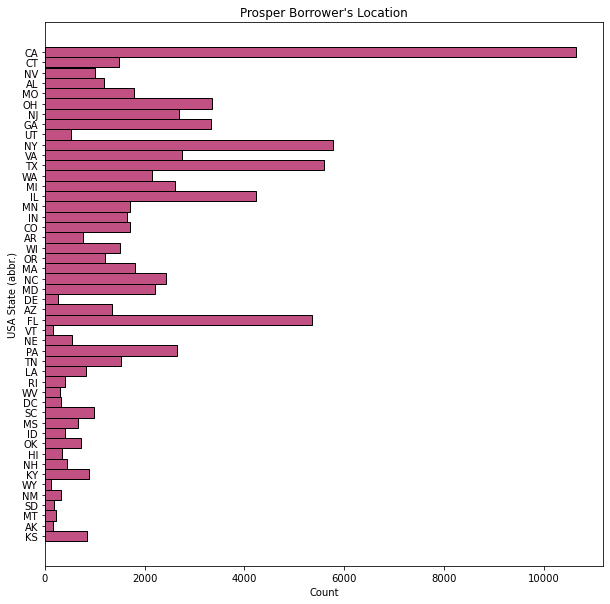

In [18]:
plt.figure( figsize=(10, 10))
sb.histplot(data=m_data, y="BorrowerState", color=sb.color_palette(palette="rocket_r")[3])
plt.title("Prosper Borrower's Location")
plt.ylabel('USA State (abbr.)')
plt.xlabel("Count");

Most borrowers appear to live in the same state as Prosper's HQ. This is not surprising. 

In [19]:
m_data.Recommendations.describe()

count    84113.000000
mean         0.017821
std          0.189117
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         19.000000
Name: Recommendations, dtype: float64

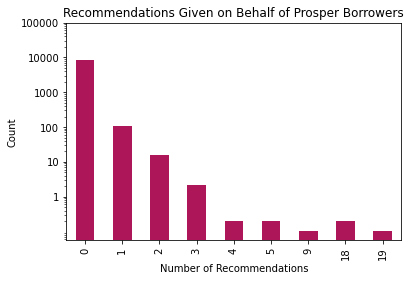

In [20]:
#logged the count so you can see all of the recommendations
m_data.Recommendations.value_counts().sort_index().plot(kind="bar", color=sb.color_palette(palette="rocket_r")[3])
plt.title('Recommendations Given on Behalf of Prosper Borrowers')
plt.xlabel("Number of Recommendations")
plt.ylabel('Count')
plt.yscale("log")
plt.yticks([10e0,10e1,10e2,10e3,10e4,10e5],[1,10,100,1000,10000,100000]);

It appears that most of Prosper's borrowers were NOT given recommendations.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

It looks like, according to both charts, that Prosper Rating is unimodal. There are also no datapoints where a borrower gets a higher Prosper Rating than a 7, which is interesting.   

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

There were unusal distribution with Debt To Income Ration (which made more sense once it was logged) and with Employment Status. It looks like Recommendations are few. We will compare the few that exist to the Prosper Rating and see if they tend to be higher.

<a id='Bivariate Exploration'></a>
## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

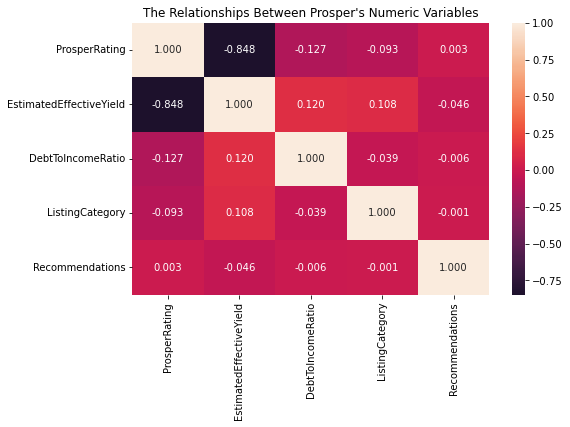

In [21]:
# Correlation plot of the numerical variables.
numeric_vars = ['ProsperRating', 'EstimatedEffectiveYield', 'DebtToIncomeRatio', 'ListingCategory', "Recommendations"]
plt.figure(figsize = [8, 5])
sb.heatmap(m_data[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'rocket', center = 0)
plt.title("The Relationships Between Prosper's Numeric Variables");

This shows the strongest correlation between Prosper Rating and Estimated Effective Yield. The next are between Estimated Effetive Yield and Debt to Income Ratio and Loan Category respectively. 

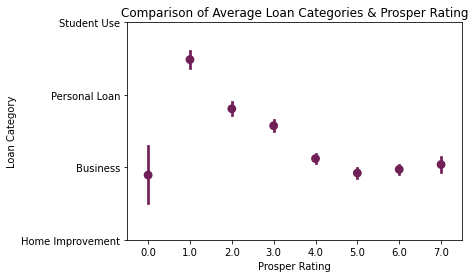

In [22]:
sb.pointplot(x="ProsperRating", y="ListingCategory", linestyles="", dodge=True, data=m_data, color=sb.color_palette(palette="rocket_r")[4])
plt.title("Comparison of Average Loan Categories & Prosper Rating")
plt.yticks(np.arange(2.0,6.0, 1), ["Home Improvement", "Business", "Personal Loan", "Student Use"])
plt.xlabel("Prosper Rating")
plt.ylabel("Loan Category");

It looks like there are some outliers when it comes to those with a Prosper Rating of 0.0. They are more likely to be business-related loans. Would Prosper be more willing to take on risk with business loans or would Prosper Rating be null when considering borrowers because it is not applicable to organizations?

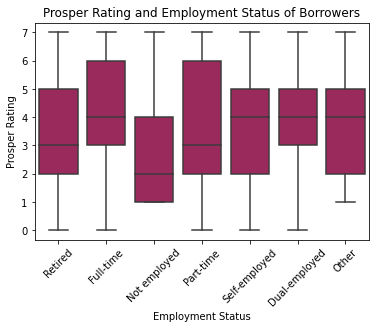

In [23]:
#better general descriptor of Employment Status and Prosper Rating
sb.boxplot(data=m_data, x="EmploymentStatus", y="ProsperRating", color=sb.color_palette(palette="rocket_r")[3])
plt.title("Prosper Rating and Employment Status of Borrowers")
plt.xlabel('Employment Status')
plt.xticks(rotation=45)
plt.ylabel('Prosper Rating');

It looks like Prosper Rating tends to Average between 3.0 and 4.0 irrespective of Employment Status

In [24]:
m_data.EmploymentStatus[m_data.ProsperRating==7].value_counts()

Dual-employed    4117
Full-time         866
Self-employed     168
Other             124
Retired            29
Part-time          16
Not employed        5
Name: EmploymentStatus, dtype: int64

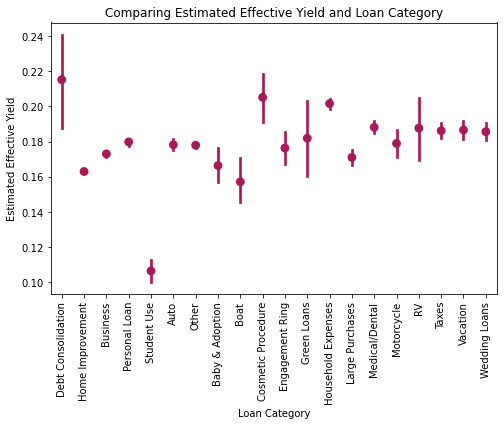

In [25]:
plt.figure(figsize = [8, 5])
sb.pointplot(data=m_data, x="ListingCategory", y="EstimatedEffectiveYield",linestyles="", dodge=True, color=sb.color_palette(palette="rocket_r")[3])
plt.title("Comparing Estimated Effective Yield and Loan Category")
plt.ylabel("Estimated Effective Yield")
plt.xlabel('Loan Category')
plt.xticks(range(0,20), listingcats, rotation=90);

It is interesting that Estimated Effective Yield is likely to be higher when the loan is listed as a Debt Consolidation loan. When looking at multivariate analysis, I will examine this relationship to see if it is impacted by Prosper Rating.  

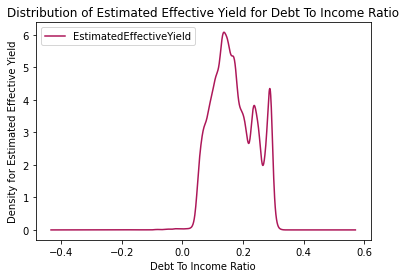

In [26]:
m_data.plot(x="DebtToIncomeRatio", y="EstimatedEffectiveYield",color=sb.color_palette(palette="rocket_r")[3], kind="density")
plt.title('Distribution of Estimated Effective Yield for Debt To Income Ratio')
plt.xlabel("Debt To Income Ratio")
plt.ylabel('Density for Estimated Effective Yield');

The density of DTI - with Estimated Effective Yield considered - is trimodal. It appears that yield is most likely to be increased when the DTI ratio is between 0.0 and 0.3, or 0% to 30%. Let's continue to look at this relationship in conjunction with Prosper Rating to see if this trend persists. 

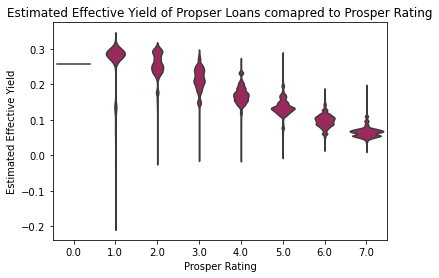

In [27]:
sb.violinplot(x=m_data.ProsperRating, y=m_data.EstimatedEffectiveYield, inner=None, color=sb.color_palette(palette="rocket_r")[3])
plt.title("Estimated Effective Yield of Propser Loans comapred to Prosper Rating")
plt.xlabel('Prosper Rating')
plt.ylabel("Estimated Effective Yield");

This shows a fairly consistent negative relationship between Prosper Rating and Estimated Effective Yield. 

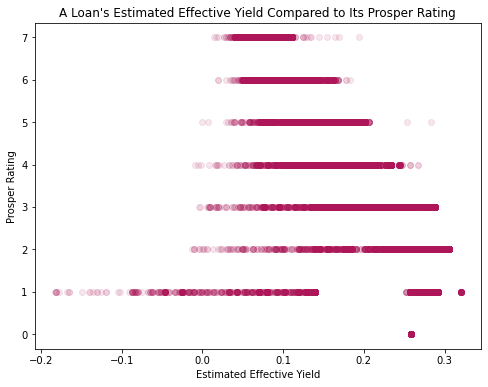

In [28]:
plt.figure(figsize = [8, 6])
plt.scatter(data = m_data, x = 'EstimatedEffectiveYield', y = 'ProsperRating', alpha = 1/10, color=sb.color_palette(palette="rocket_r")[3])
plt.xlabel('Estimated Effective Yield')
plt.ylabel('Prosper Rating')
plt.title("A Loan's Estimated Effective Yield Compared to Its Prosper Rating");

This shows the range of the Yield as continued. 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

For the most part, there doesn't seem to be an correlation between my chosen features and my feature of interest. One relationships that show potential is the negative correlation between Prosper Rating and Estimated Effective Yield. This is what we will look at going forward to see if any of the other factors could be contributing to that relationship. Especially since it looks like there may be outliers in Rating 0.0 and 1.0 that are affecting the relationship between Estimated Effective Yield. 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

The closest relationships, besides Estimated Effective Yield and Propser Rating, are those between Estimated Effective Yield compared Debt To Income Ratio and Estimated Effective Yield compared to Loan/Listing Category. I still think a borrower's Employment Status could have some impact and will look at that in conjunction with the other variables. 

<a id='Multivariate Exploration'></a>
## Multivariate Exploration

In [29]:
m_data.EstimatedEffectiveYield.describe(), m_data.DebtToIncomeRatio.describe()

(count    84113.000000
 mean         0.169010
 std          0.068645
 min         -0.182700
 25%          0.116600
 50%          0.161620
 75%          0.225400
 max          0.319900
 Name: EstimatedEffectiveYield, dtype: float64,
 count    84113.000000
 mean         0.258679
 std          0.306039
 min          0.000000
 25%          0.160000
 50%          0.240000
 75%          0.310000
 max         10.010000
 Name: DebtToIncomeRatio, dtype: float64)

In [30]:
def hist2dgrid(x, y, **kwargs):
    """ Quick hack for creating heat maps with seaborn's PairGrid. """
    palette = kwargs.pop('color')
    bins_x = np.arange(0.00, 0.31 +0.1, 0.1)
    bins_y = np.arange(-0.2, 0.31+0.1, 0.1)
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 0.5)

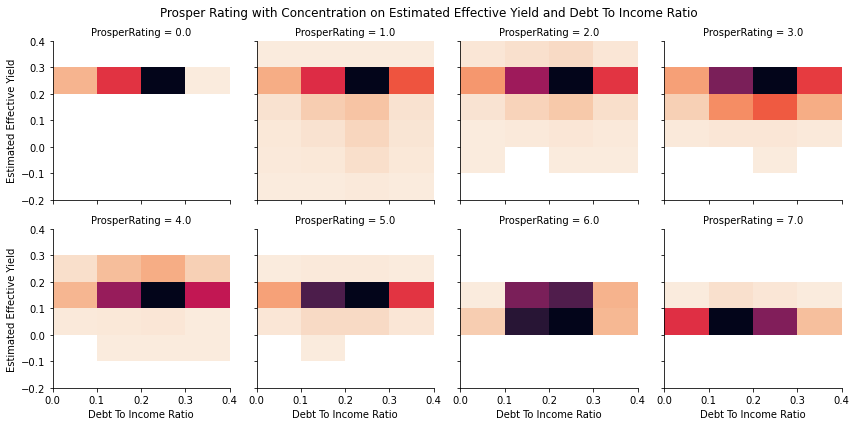

In [31]:
# create faceted heat maps on levels of the cut variable
graph2 = sb.FacetGrid(data = m_data, col = 'ProsperRating', col_wrap = 4, height = 3)
graph2.map(hist2dgrid, 'DebtToIncomeRatio', 'EstimatedEffectiveYield', color = 'rocket_r')
graph2.set_xlabels('Debt To Income Ratio')
graph2.set_ylabels('Estimated Effective Yield')
graph2.fig.subplots_adjust(top=0.9)
graph2.fig.suptitle("Prosper Rating with Concentration on Estimated Effective Yield and Debt To Income Ratio");

The concentrations are mostly between Debt to Income Ratio and Estimated Effective Yield. 

In [32]:
m_data.ProsperRating.value_counts()

4.0    18096
5.0    15368
6.0    14390
3.0    14170
2.0     9716
1.0     6917
7.0     5325
0.0      131
Name: ProsperRating, dtype: int64

In [33]:
m_data.ListingCategory.describe()

count    84113.000000
mean         3.321104
std          4.366494
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         20.000000
Name: ListingCategory, dtype: float64

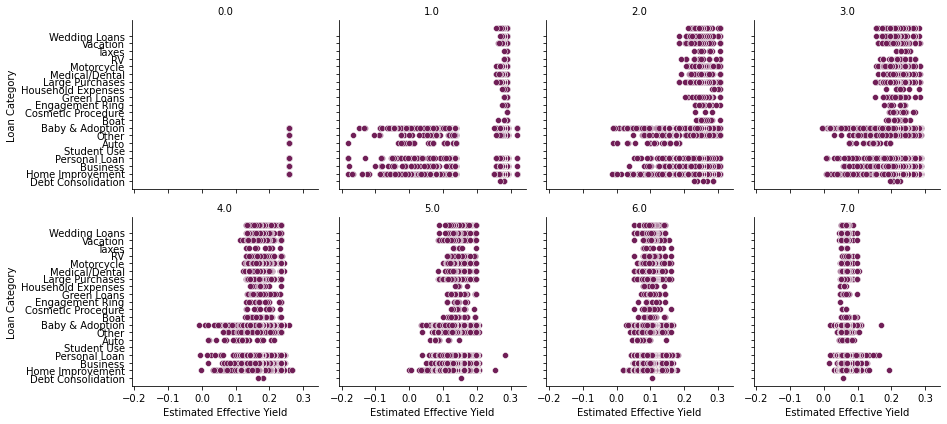

In [34]:
graph3 = sb.FacetGrid(m_data, col="ProsperRating", col_wrap=4, margin_titles=True)
graph3.map_dataframe(sb.scatterplot, x="EstimatedEffectiveYield", y="ListingCategory", color=sb.color_palette(palette="rocket_r")[4])
graph3.set_axis_labels("Estimated Effective Yield", "Loan Category")
graph3.set_titles(col_template="{col_name}")
plt.yticks(np.arange(20), listingcats);

Prosper Rating and Estimated Effective Yield are still showing their relationship. It is interesting to note that Prosper Rating seems to have little effect on type of loan. The distribution looks fairly consistent. 

CITE: https://www.delftstack.com/howto/seaborn/legend-seaborn-plot/

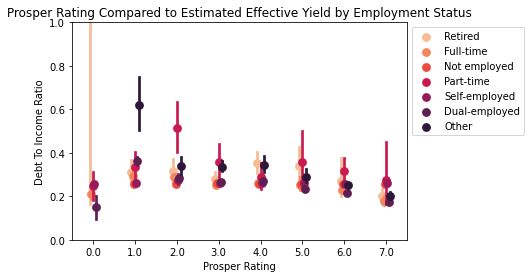

In [35]:
sb.pointplot(x="ProsperRating", y="DebtToIncomeRatio", hue="EmploymentStatus", palette="rocket_r", linestyles="", dodge=True, data=m_data)
plt.title('Prosper Rating Compared to Estimated Effective Yield by Employment Status')
plt.xlabel('Prosper Rating')
plt.ylabel("Debt To Income Ratio")
plt.legend(loc = 2, bbox_to_anchor = (1,1))
plt.ylim([0,1]);

Retired persons with a Proper Rating of 0.0 seem to account for a lot of the variance in DTI as a variable. The concentration otherwise still sits around 0.2 to 0.4.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

For the hist2d grid, it emphasized that DTI concentrates at 0.2-0.3 regardless of Prosper Rating, indicating little to no relationship with Rating. The relationship we first saw with Estimated Effective Yield and Prosper Rating does continue when considering the Debt to Income Ratio. Distributions of Estimated Effective Yield doesn't change when looking at which category the loan resides. It is interesting to note that as Prosper Rating increases, Estimated Effective Yield no longer has negative values, but after Prosper Rating 5.0, Yield no longer reaches its maximum value either.  

### Were there any interesting or surprising interactions between features?

Estimated Effective yield, regardless of Prosper Rating, concentrates between 0.01 and 0.03, which is shown on both grid sets. DTI also tends to concentrate in the same region as Yield regardless of Prosper Rating. This is likely because the number of borrowers in this range are higher with both variables. It is interesting to note that a retired borrower is more likely to have a higher DTI when at a Rating of 0.0. 

<a id='conclusions'></a>
## Conclusions

In this exploration, there are some of the non-credit report based variables that could impact a borrower's Prosper Rating. Prosper Rating is part two of Prosper's loan evaluation tool. According to the introduction, variables most likely to correlate with a high Prosper Rating are a borrower's Debt to Income Ratio (positive), Recommendations given on behalf of the borrower (positive), Employment Status, their location, as well as Prosper's estimated effective yield, or net interest rate and purpose of loan. The thought being that a borrower's recommendation (therefore personal status) and the Estimated Effective Yield of the loan (the company's financial gain) are the two most likely factors to impact a borrower's Prosper Rating.

When looking at correlations between variables, the strongest appear to be Prosper Rating and Estimated Effective Yield, Estimated Effective Yield and DTI, and Estimated Effective Yield and Loan Category. The relationships between Loan Category, DTI, and Estimated Effective Yield could impact the relationship between Estimated Effective Yield and Prosper Rating. The relationship between Prosper Rating and Recommendations shows as minimal and therefore is dismissed from consideration, as is the borrower's location.

Even with the concentrations between Yield and DTI correlating, Prosper Rating does show a slight decrease in Yield as Rating increases. Also, excluding Rating 0.0, Prosper Rating does narrow the range of Yield, so even though Yield concentration remains fairly consistent, you can see that a lower Rating means a borrower is more likely to meet the minimum or the maximum Yield. Loan Category is fairly spread out in all but Rating 0.0 and doesn't appear to affect the relationship between Yield and Rating. 

What this tells me is that Yield correlates negatively with Rating, because Yield has a larger range when Rating is lower-disregarding Rating 0.0- and that range favors its maximum more than its minimum. All other variables: Debt to Income Ratio, Borrower's State, Recommendations, Borrower's Employment Status and Loan Category, do not show correlation with Prosper's Rating metric. 